Claims Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123361 entries, 0 to 123360
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Truck Number      123361 non-null  object
 1   Claim Number      123361 non-null  object
 2   Scale Claim Cost  123361 non-null  object
 3   Scale Labor Cost  123361 non-null  object
dtypes: object(4)
memory usage: 3.8+ MB
None

Claims Dataset Preview:
  Truck Number Claim Number Scale Claim Cost Scale Labor Cost
0   Truck 4208      Claim 1         Very Low         Very Low
1  Truck 22899      Claim 2         Very Low         Very Low
2  Truck 22899      Claim 3         Very Low         Very Low
3   Truck 9983      Claim 4         Very Low         Very Low
4   Truck 2426      Claim 5         Very Low         Very Low

Missing Values in Claims Dataset:
Truck Number        0
Claim Number        0
Scale Claim Cost    0
Scale Labor Cost    0
dtype: int64
Options D

/var/folders/z4/rmcbqkwn7rj8vphlz5td69hm0000gn/T/ipykernel_25939/2909456085.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index, palette="viridis")


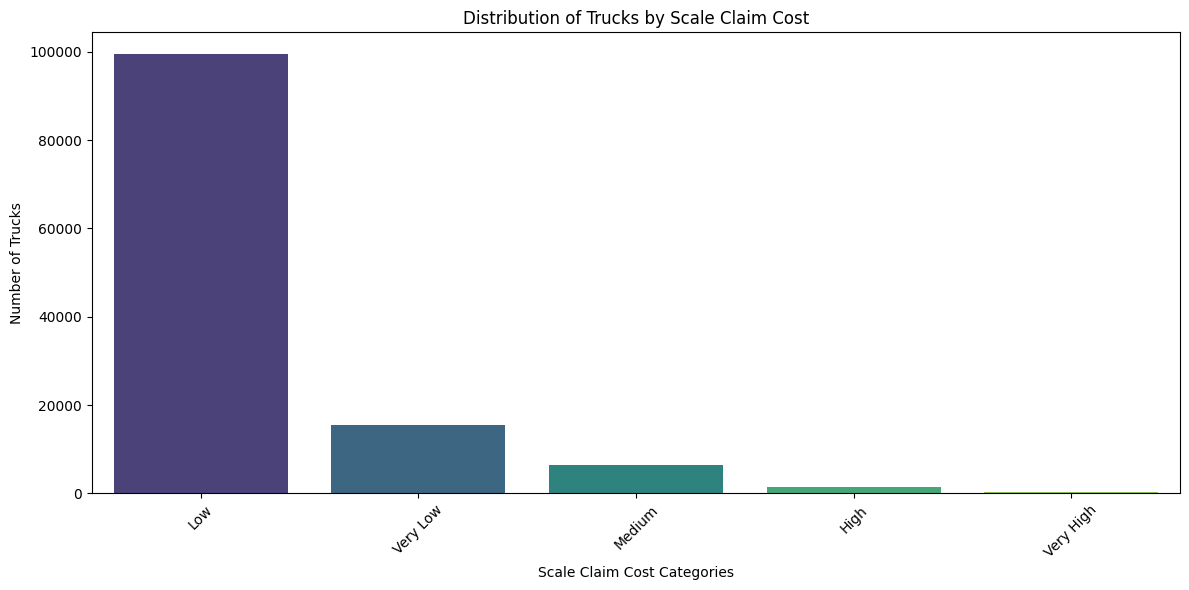

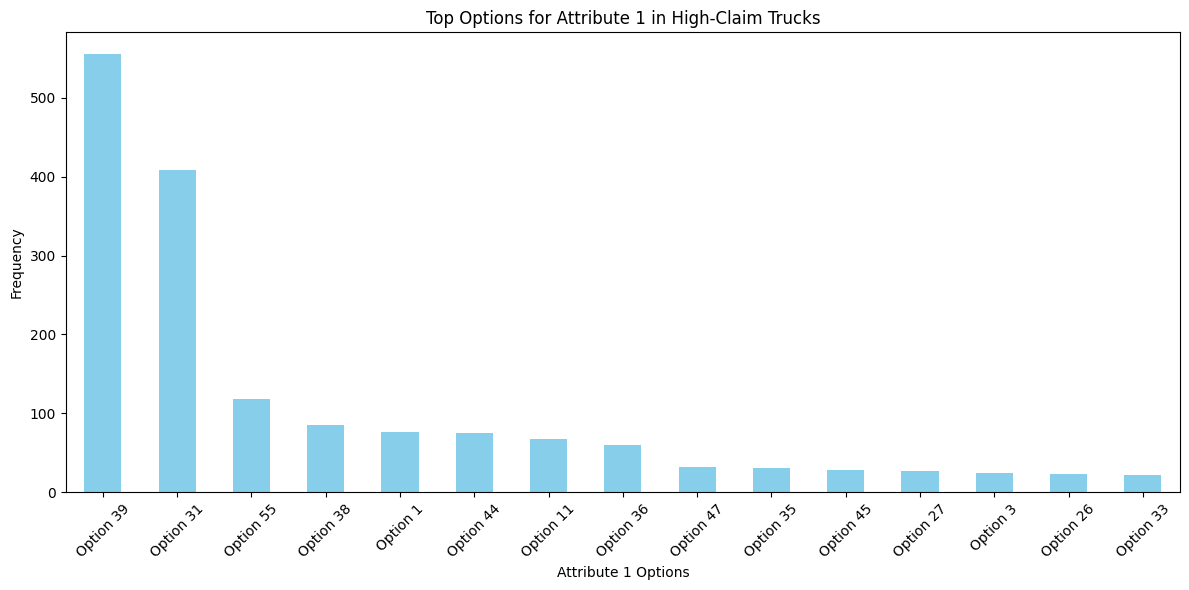

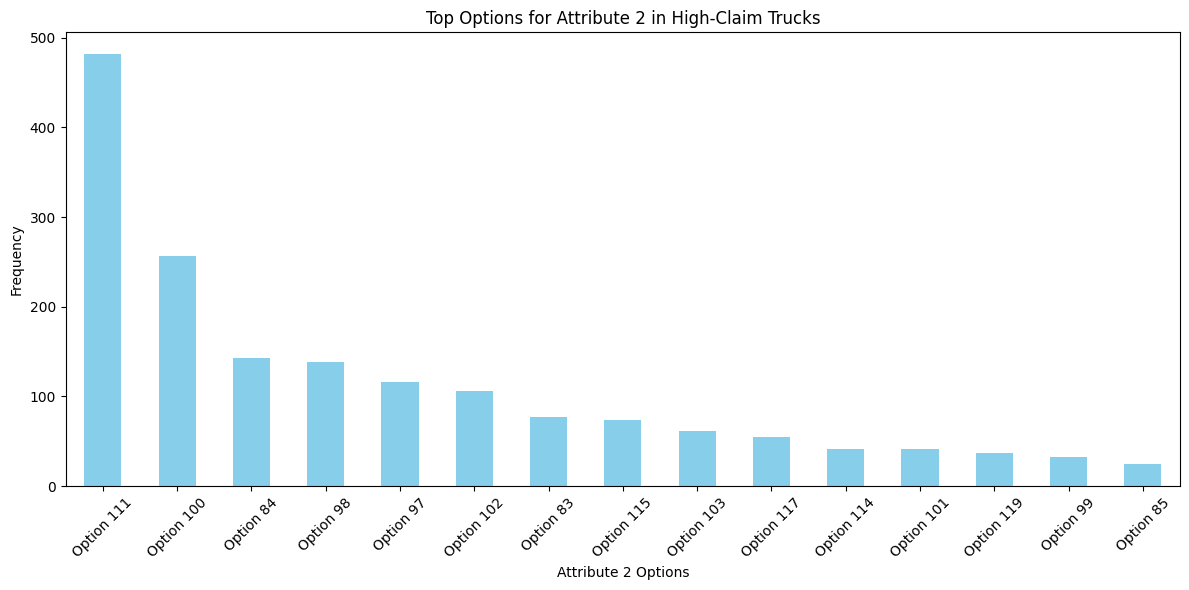

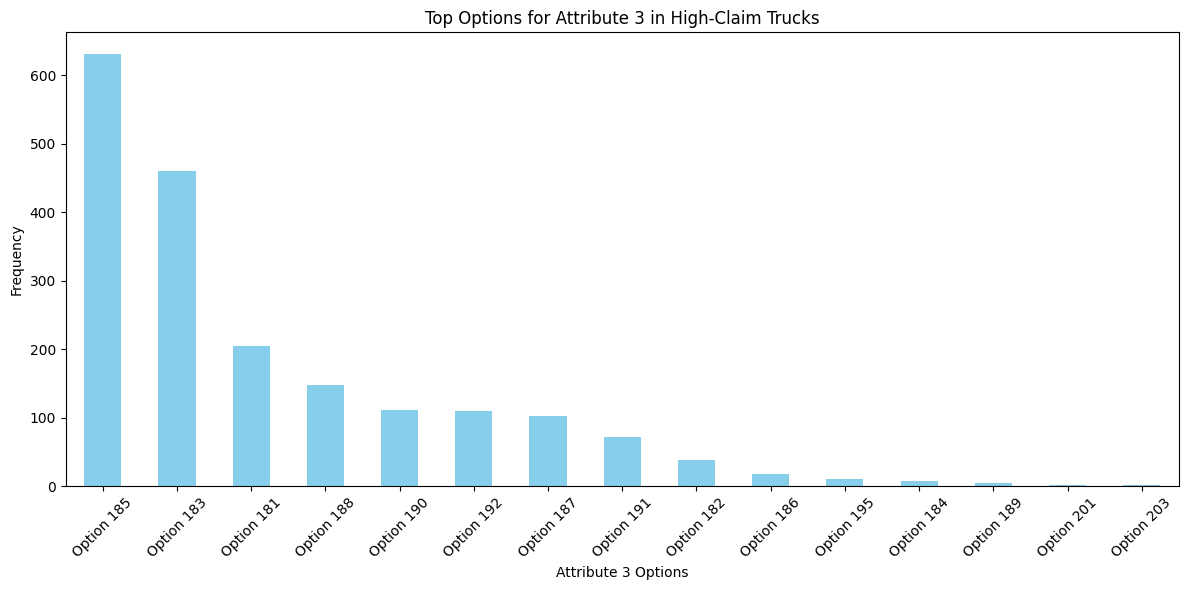

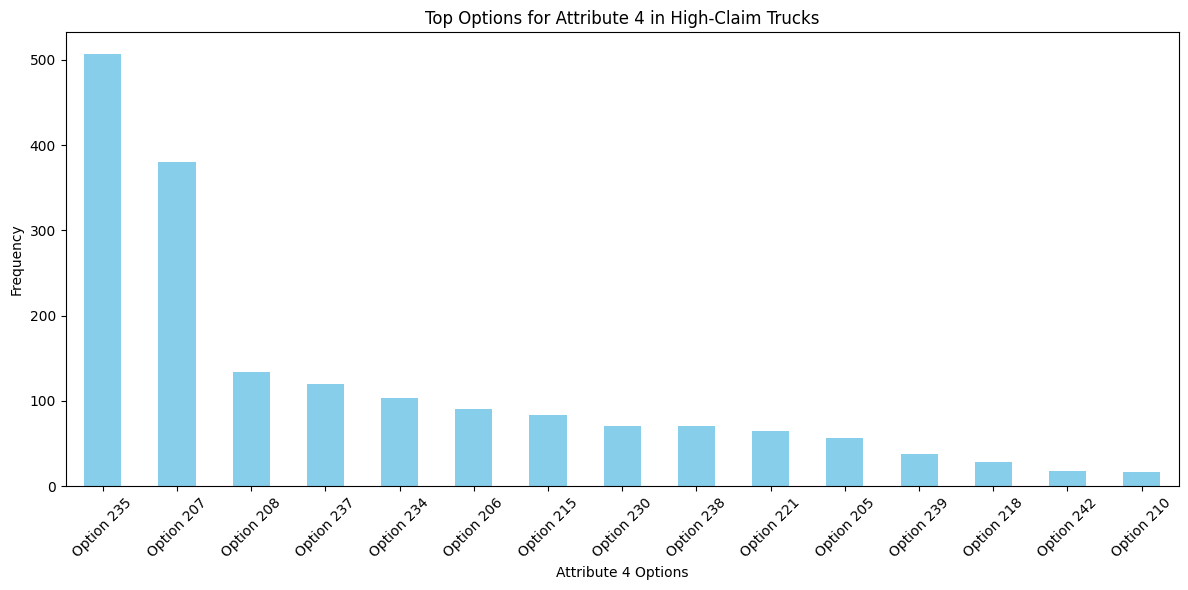

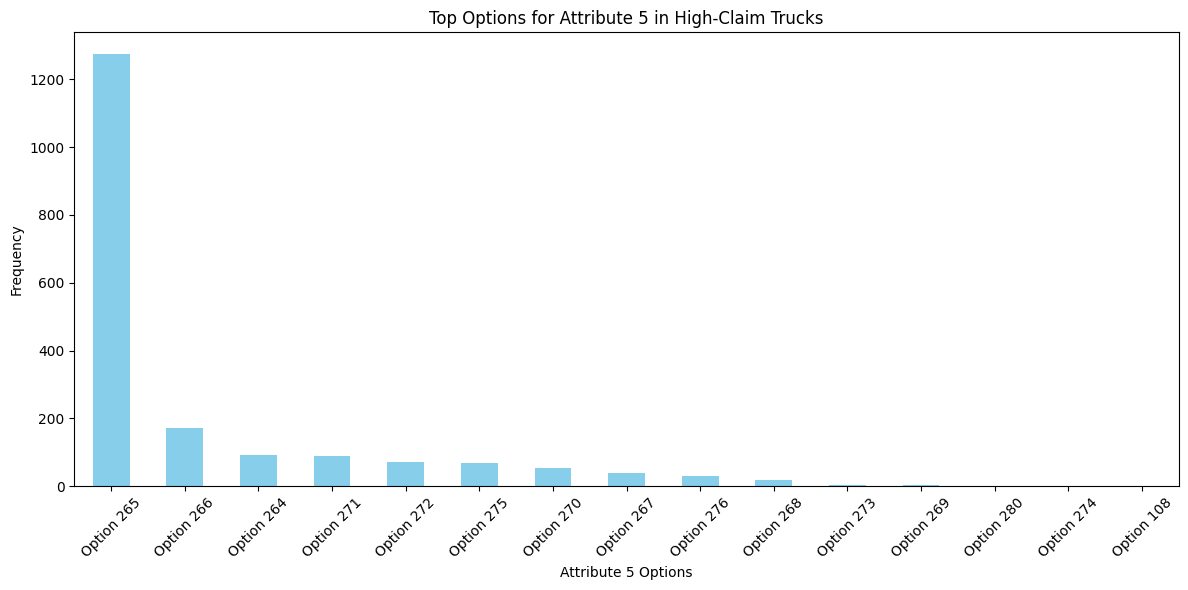

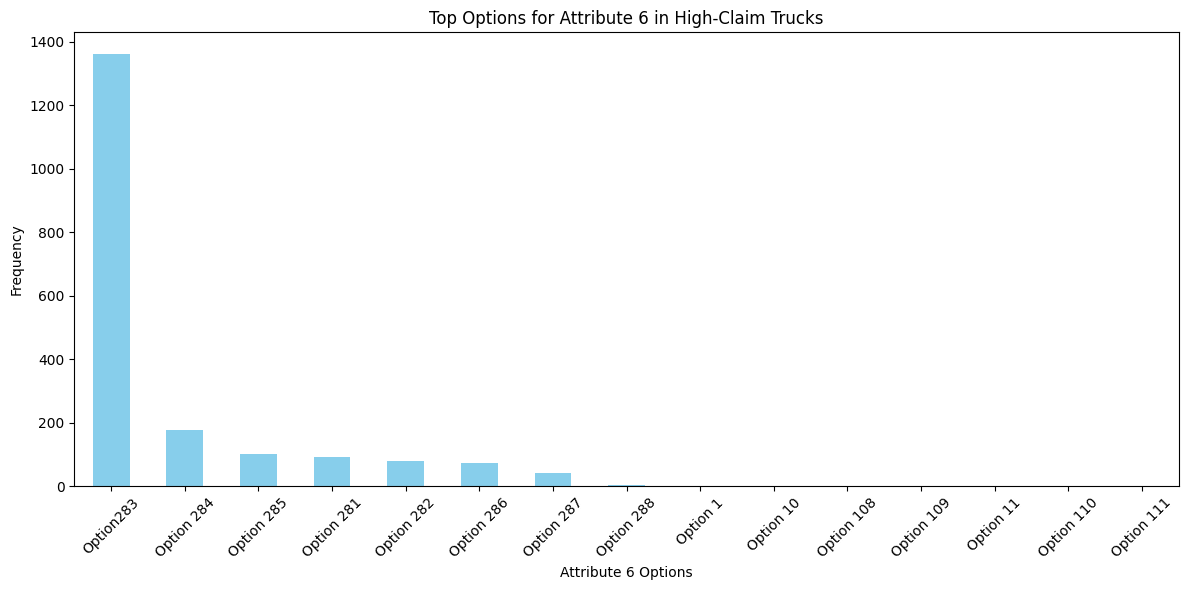

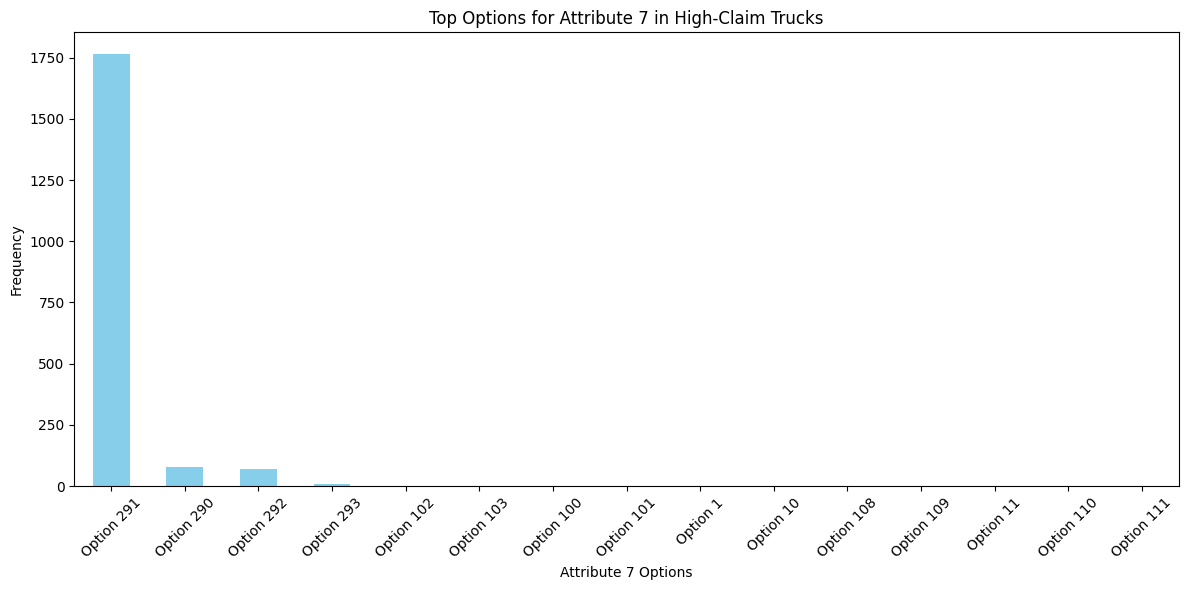

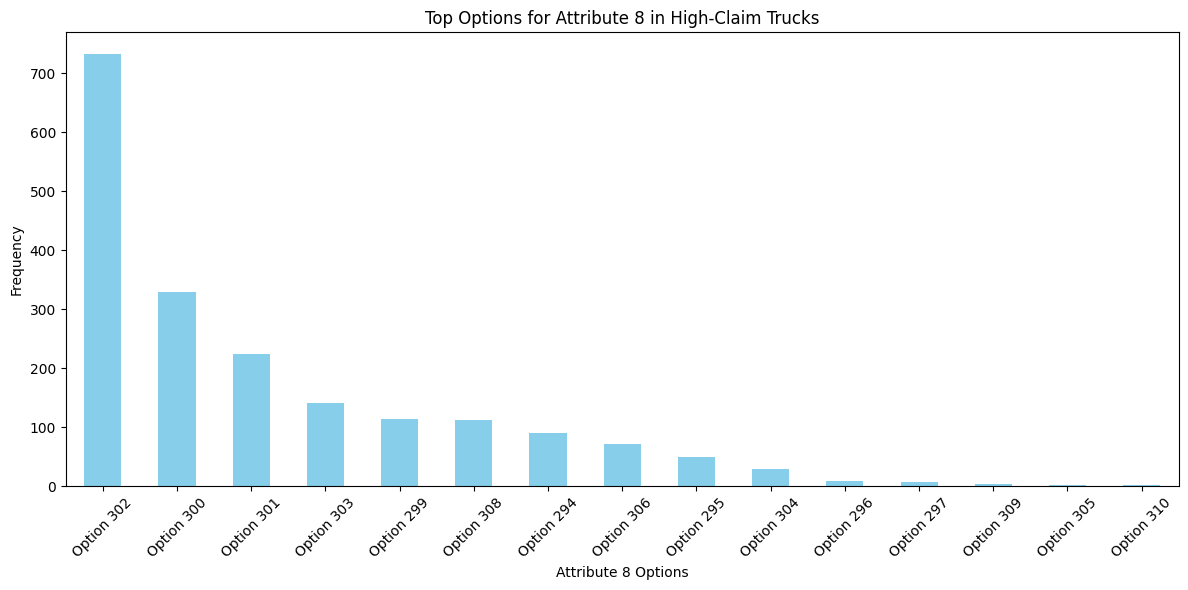

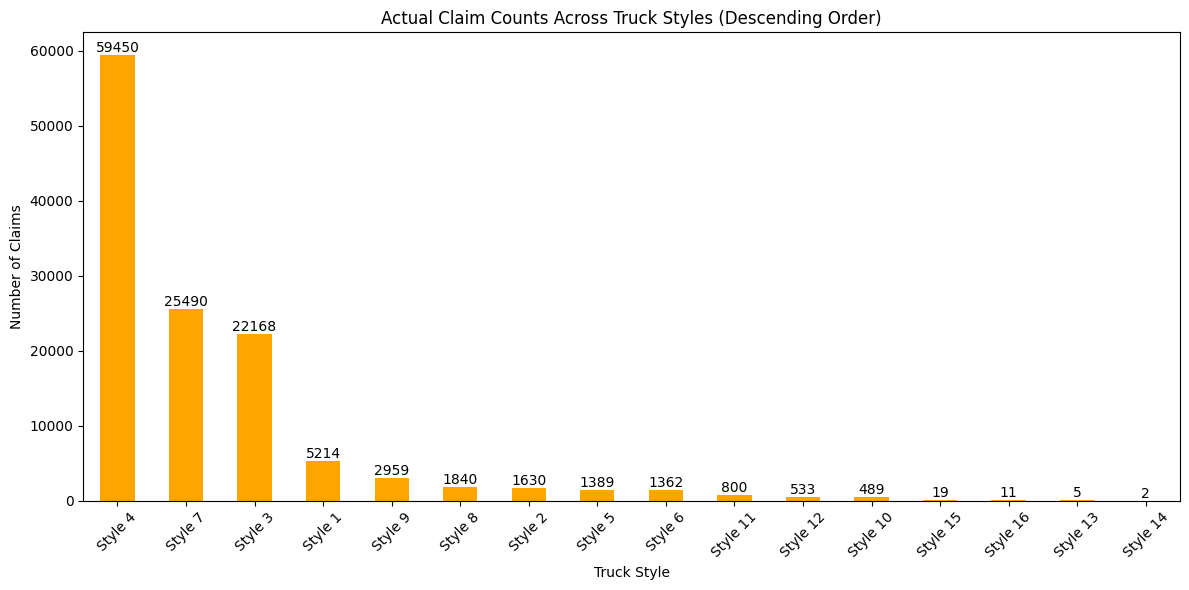

/var/folders/z4/rmcbqkwn7rj8vphlz5td69hm0000gn/T/ipykernel_25939/2909456085.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_combinations, x='Count', y='Attribute Pair', palette='viridis')


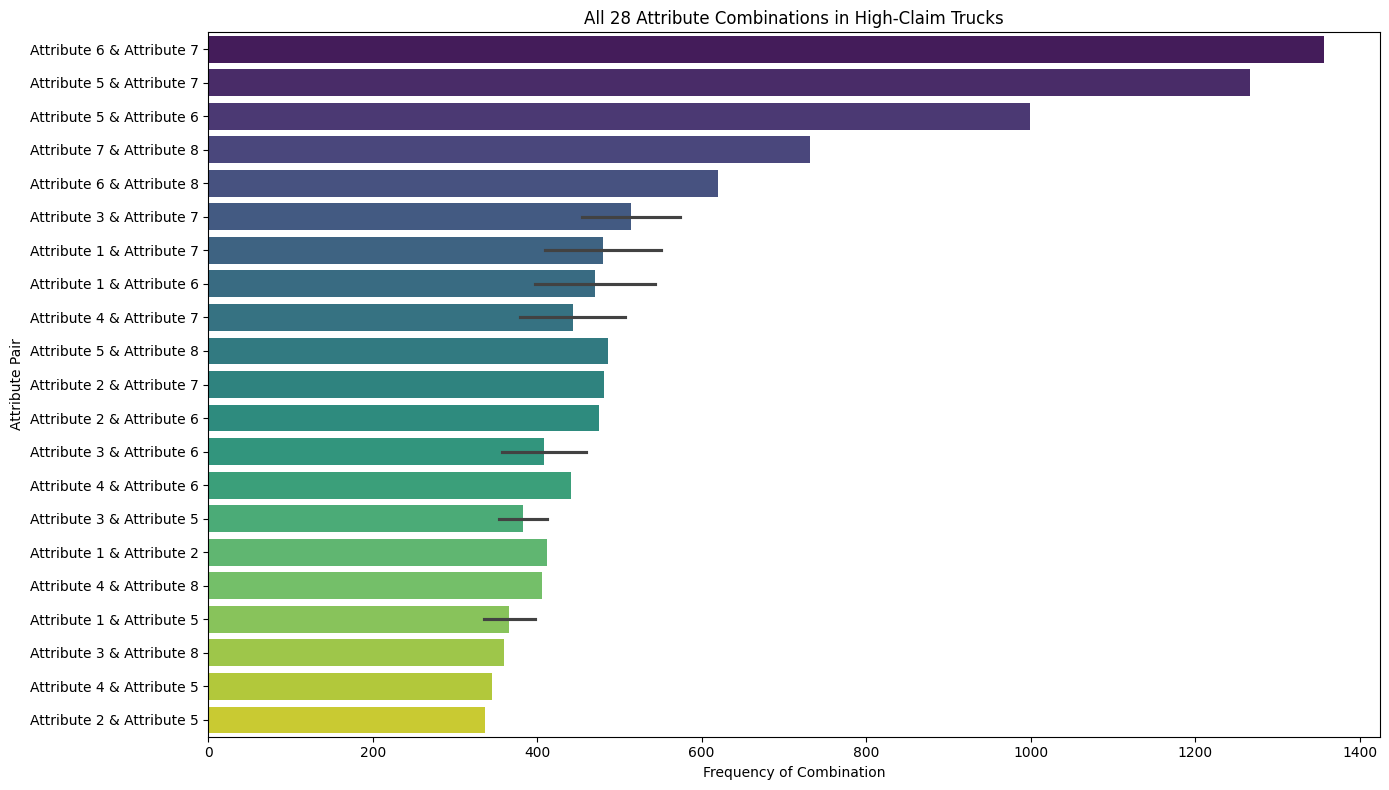

In [3]:

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import statsmodels.api as sm

# File paths (use relative paths for portability)
claims_path = "/Users/jeevandeep/Downloads/Hackathon/Data/Claim Information file for UNT.xlsx"
options_path = "/Users/jeevandeep/Downloads/Hackathon/Data/Option Code Information file for UNT - Final.xlsx"

# Load datasets
claims_df = pd.read_excel(claims_path)
options_df = pd.read_excel(options_path)

# Function to display basic info and missing values
def display_dataset_info(df, dataset_name):
    print(f"{dataset_name} Info:")
    print(df.info())
    print(f"\n{dataset_name} Preview:")
    print(df.head())
    print(f"\nMissing Values in {dataset_name}:")
    print(df.isnull().sum())

# Displaying dataset information
display_dataset_info(claims_df, "Claims Dataset")
display_dataset_info(options_df, "Options Dataset")

# Function to count categories in a specified column
def count_categories(df, column_name, dataset_name):
    print(f"\nCategory Counts in {column_name} ({dataset_name}):")
    counts = df[column_name].value_counts()
    print(counts)
    return counts

# Count categories for "Scale Claim Cost" and "Scale Labor Cost" in Claims Dataset
claim_cost_counts = count_categories(claims_df, "Scale Claim Cost", "Claims Dataset")


# Visualizing the distribution of claim categories
def plot_claim_categories(df, column_name, title):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index, palette="viridis")
    plt.title(title)
    plt.xlabel(f'{column_name} Categories')
    plt.ylabel('Number of Trucks')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting the distribution of Scale Claim Cost
plot_claim_categories(claims_df, "Scale Claim Cost", "Distribution of Trucks by Scale Claim Cost")

#### Question 1:
 
# Filtering high-claim trucks
high_claims = claims_df[claims_df['Scale Claim Cost'].isin(['High', 'Very High'])]

# Merge high-claim trucks with options data to analyze attributes
merged_high_claims = pd.merge(high_claims, options_df, left_on="Truck Number", right_on="Truck")

# Analyze attribute frequencies in high-claim trucks
attribute_columns = [col for col in options_df.columns if "Attribute" in col]
high_claim_attributes = {}

for attribute in attribute_columns:
    # Count occurrences of each option in high-claim trucks
    high_claim_attributes[attribute] = merged_high_claims[attribute].value_counts()

# Convert to DataFrame for visualization
high_claim_attributes_df = pd.DataFrame(high_claim_attributes).fillna(0)

# Visualize top options for each attribute in high-claim trucks
for attribute in high_claim_attributes_df.columns:
    plt.figure(figsize=(12, 6))
    high_claim_attributes_df[attribute].sort_values(ascending=False).head(15).plot(kind='bar', color='skyblue')
    plt.title(f"Top Options for {attribute} in High-Claim Trucks")
    plt.xlabel(f"{attribute} Options")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Merge claims with options to include Style
merged_claims = pd.merge(claims_df, options_df, left_on="Truck Number", right_on="Truck")

# Calculate the total number of claims for each style
style_claim_counts = merged_claims.groupby("Style")['Claim Number'].count()

# Sort claim counts in descending order
style_claim_counts = style_claim_counts.sort_values(ascending=False)

# Visualize actual claim counts across styles
plt.figure(figsize=(12, 6))
style_bar = style_claim_counts.plot(kind='bar', color='orange')

# Add actual counts on top of bars
for i, value in enumerate(style_claim_counts):
    plt.text(i, value, f"{value}", ha='center', va='bottom', fontsize=10)  # Annotate each bar

plt.title("Actual Claim Counts Across Truck Styles (Descending Order)")
plt.xlabel("Truck Style")
plt.ylabel("Number of Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Question 2:

from itertools import combinations

# Step 2: Generate Attribute Pairs and Count Frequencies
# List of attributes
attribute_columns = [col for col in options_df.columns if "Attribute" in col]

# Create pairwise combinations of attributes
attribute_pairs = list(combinations(attribute_columns, 2))

# Count occurrences of each attribute combination
combination_counts = {}

for attr1, attr2 in attribute_pairs:
    # Create a tuple of attribute options for each truck
    pairs = merged_high_claims[[attr1, attr2]].apply(tuple, axis=1)
    # Count unique combinations
    pair_counts = pairs.value_counts()
    combination_counts[(attr1, attr2)] = pair_counts

# Convert results into a DataFrame for easier analysis
combination_df = pd.DataFrame([
    {'Attribute Pair': f'{attr1} & {attr2}', 'Combination': comb, 'Count': count}
    for (attr1, attr2), counts in combination_counts.items()
    for comb, count in counts.items()
]).sort_values(by='Count', ascending=False)

# Step 3: Visualize Top Attribute Combinations
# Plot the top 10 combinations
top_combinations = combination_df.head(28)
plt.figure(figsize=(14, 8))
sns.barplot(data=top_combinations, x='Count', y='Attribute Pair', palette='viridis')
plt.title("All 28 Attribute Combinations in High-Claim Trucks")
plt.xlabel("Frequency of Combination")
plt.ylabel("Attribute Pair")
plt.tight_layout()
plt.show()
